<a href="https://colab.research.google.com/github/droderuan/data-science-and-ml/blob/main/faculdade/trabalho_carro_olx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise do dataset de carros usados do olx

## Objetivo: Prever o preço dos carros e identificar as features que melhor explicam seu preço

Feito por: Ruan Ferreira

Matrícula: 201839021-8

Fonte: https://www.kaggle.com/trolukovich/olx-auto

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
import math
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (mean_squared_error,r2_score)
import lightgbm as lgb


In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

### Importando o arquivo e deletando linhas com valores nulls

In [ ]:
dir = '/content/drive/MyDrive/Faculdade/7 periodo/tópicos especiais em si/trabalho'

In [ ]:
cars_df = pd.read_csv(dir + '/cars_ver2.csv', encoding = 'windows-1251')
cars_df.columns = cars_df.columns.map(lambda x: x.lower())
cars_df.dropna(inplace=True)

### Um pouco da aparência dos dados

In [ ]:
cars_df.head(5)

,unnamed: 0,title,pub_date,views,city,region,mark,model,year,mileage,body_type,color,engine_vol,fuel,gearbox,cleared,condition,add_opt,multimedia,security,other,owner_note,price,category
1,1.0,SsangYong corando (4wd)Dlx-3/,10.05.2019,68.0,Кривой Рог,Днепропетровская область,other,Korando,2013.0,76000.0,SUV / Crossover,Black,2000.0,Diesel,Automatic,1.0,"[Гаражное хранение, Не бит, Не крашен, Первая ...","['Бортовой компьютер', 'Датчик света', 'Климат...","['CD', 'AUX', 'Bluetooth', 'USB', 'Акустика', ...","['ABD', 'ABS', 'ESP', 'Галогенные фары', 'Иммо...","['Тонирование стекол', 'Тюнинг']","Автомобиль в хорошем состоянии, вложений не тр...",12600.0,luxury
2,2.0,Suzuki Vitara 1998 газ/бензин 1.6л Винница,10.05.2019,1809.0,Винница,Винницкая область,other,other,1998.0,2000.0,SUV / Crossover,Cherry,1600.0,Gas / petrol,Mechanical,1.0,"[Гаражное хранение, Не бит]","['Кондиционер', 'Электропакет', 'Эл. стеклопод...","['Акустика', 'Bluetooth', 'CD', 'Магнитола', '...","['ABS', 'Подушка безопасности (Airbag)', 'Цент...","['Газовая установка (ГБО)', 'Тонирование стеко...","Продам хороший внедорожник ,все работает,остал...",8150.0,expensive
8,NaN,NaN,NaN,NaN,NaN,NaN,other,other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[other],NaN,NaN,NaN,NaN,NaN,NaN,luxury
12,12.0,Bmw e46 може бути Обмін,10.05.2019,1851.0,Лапаевка,Львовская область,BMW,3 серия,1998.0,265000.0,Sedan,Black,2000.0,Diesel,Mechanical,1.0,"[Не бит, Первый владелец]","['Кондиционер', 'Климат контроль', 'Эл. стекло...","['CD', 'Магнитола', 'Акустика']","['Галогенные фары', 'Иммобилайзер', 'Подушка б...",['Тонирование стекол'],Авто в хорошому стані детальніше за телефоном,5999.0,expensive
15,15.0,Продам шкоду 1.6тді,10.05.2019,1512.0,Стрый,Львовская область,Skoda,Octavia,2012.0,212.0,Universal,Black,16.0,Diesel,Mechanical,1.0,"[Гаражное хранение, Не бит, Не крашен, Первая ...","['Кондиционер', 'Климат контроль', 'Круиз конт...","['Акустика', 'AUX', 'Bluetooth', 'CD', 'Систем...","['ABD', 'ABS', 'Подушка безопасности (Airbag)'...",['Тонирование стекол'],продам свіжопригнану шкоду на дуже гарній комп...,9900.0,luxury


In [ ]:
cars_df.describe()

,unnamed: 0,views,year,mileage,engine_vol,cleared,price
count,6669.000000,6669.00000,6669.000000,6.669000e+03,6669.000000,6669.000000,6669.000000
mean,9881.419703,1889.45839,2004.586895,1.497186e+05,1597.990553,0.879292,7746.854101
std,5790.031520,3579.15943,7.397458,1.854500e+05,3223.506261,0.325812,6877.825035
min,1.000000,1.00000,1900.000000,0.000000e+00,1.000000,0.000000,0.000000
25%,4817.000000,328.00000,2001.000000,1.200000e+04,1300.000000,1.000000,3600.000000
50%,9826.000000,830.00000,2006.000000,1.500000e+05,1600.000000,1.000000,6250.000000
75%,14975.000000,2137.00000,2010.000000,2.320000e+05,2000.000000,1.000000,9500.000000
max,19836.000000,123607.00000,2019.000000,1.000000e+07,249700.000000,1.000000,80000.000000


In [ ]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6669 entries, 1 to 19836
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   unnamed: 0  6669 non-null   int64  
 1   title       6669 non-null   object 
 2   pub_date    6669 non-null   object 
 3   views       6669 non-null   int64  
 4   city        6669 non-null   object 
 5   region      6669 non-null   object 
 6   mark        6669 non-null   object 
 7   model       6669 non-null   object 
 8   year        6669 non-null   int64  
 9   mileage     6669 non-null   int64  
 10  body_type   6669 non-null   object 
 11  color       6669 non-null   object 
 12  engine_vol  6669 non-null   int64  
 13  fuel        6669 non-null   object 
 14  gearbox     6669 non-null   object 
 15  cleared     6669 non-null   float64
 16  condition   6669 non-null   object 
 17  add_opt     6669 non-null   object 
 18  multimedia  6669 non-null   object 
 19  security    6669 non-null 

### Gráficos para entedermos melhor os dados

No gráfico abaixo, queria ver como esta a distribuição dos carros com base em alguma categoria, que nesse caso foi o tipo de câmbio. O gráfico está em escala logarítmica.

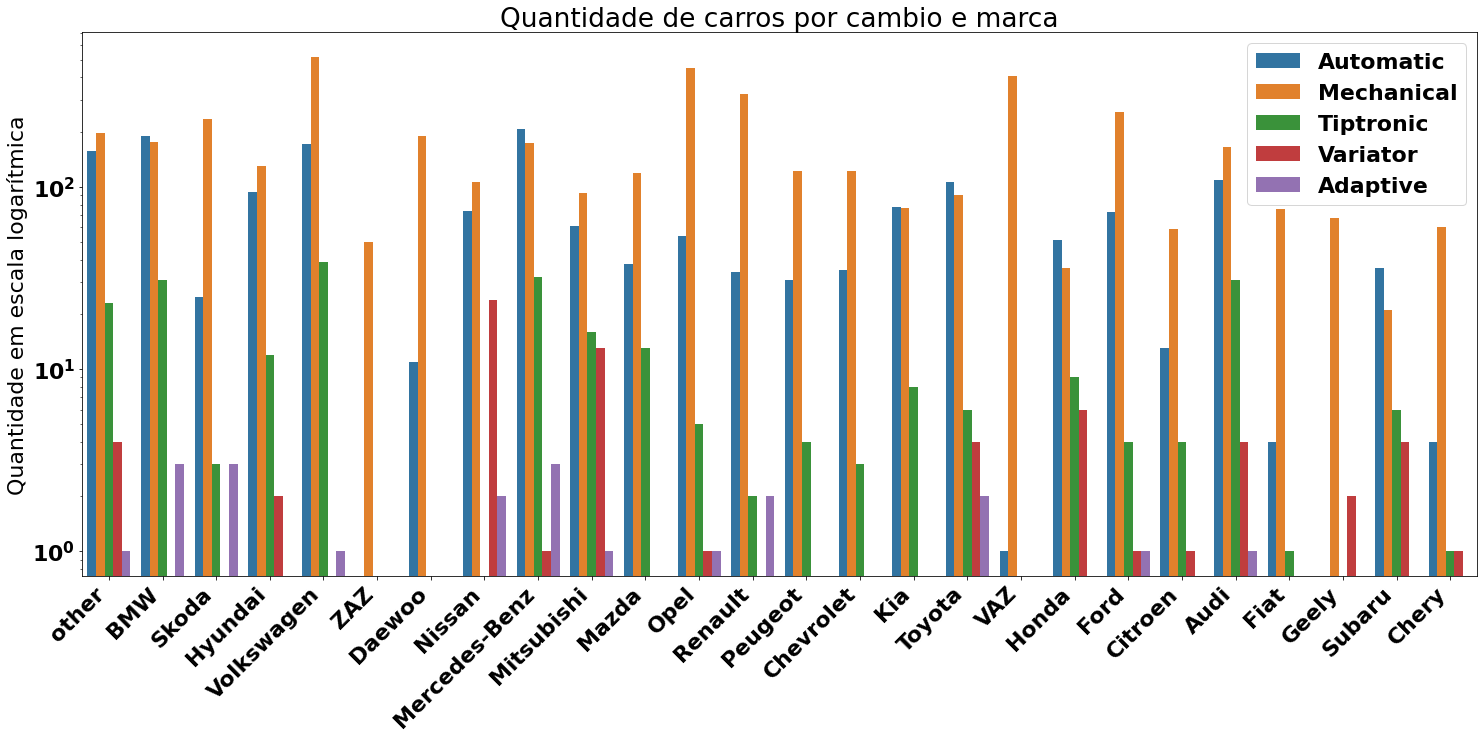

In [ ]:
plt.figure(figsize=(25,10)) 
plt.title('Quantidade de carros por cambio e marca') 
g = sns.countplot(x="mark", hue="gearbox", data=cars_df)
g.set_yscale("log")
g.set(xlabel=None, ylabel="Quantidade em escala logarítmica")
plt.legend(loc="upper right")
g.set_xticklabels(g.get_xticklabels(), rotation = 45, ha="right")
plt.setp(g.get_legend().get_texts(), fontsize='22') 
plt.setp(g.get_xticklabels(), fontsize='22') 
plt.show()

Nesse gráfico, busquei ver se existe alguma correlação linear entre as variáveis discretas. Podemos perceber que não há.

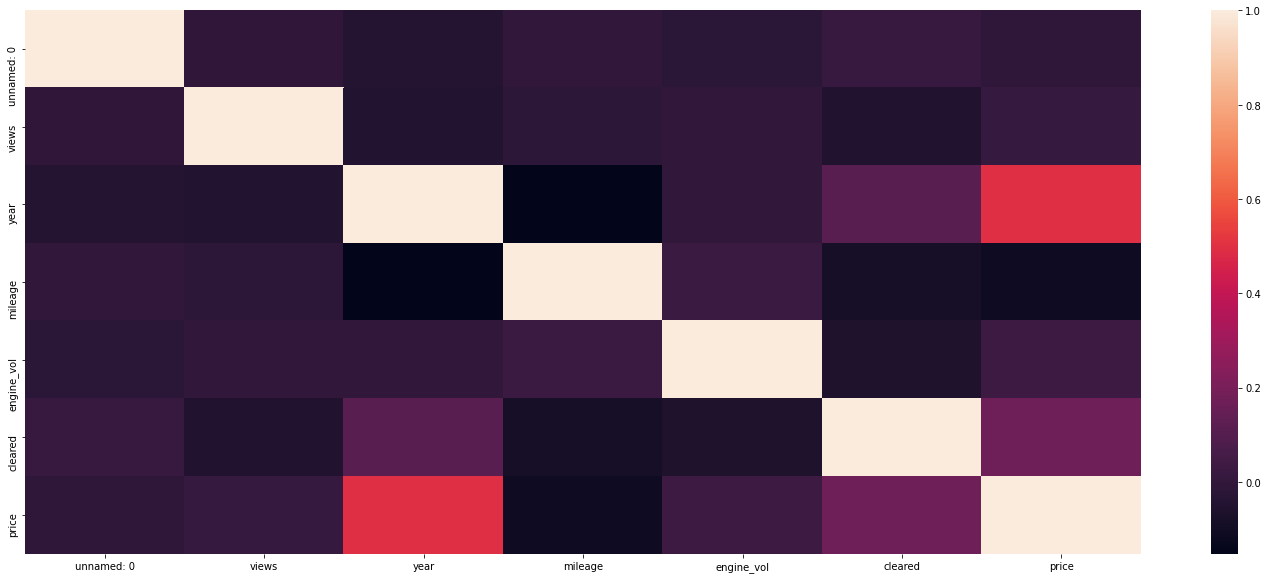

In [ ]:
plt.figure(figsize=(25,10))
sns.heatmap(cars_df.dropna().corr())
plt.show()

No próximo gráfico, podemos ver a média de preço por marca. Marcas de luxo estão condizentes com o que esperaríamos da realidade.

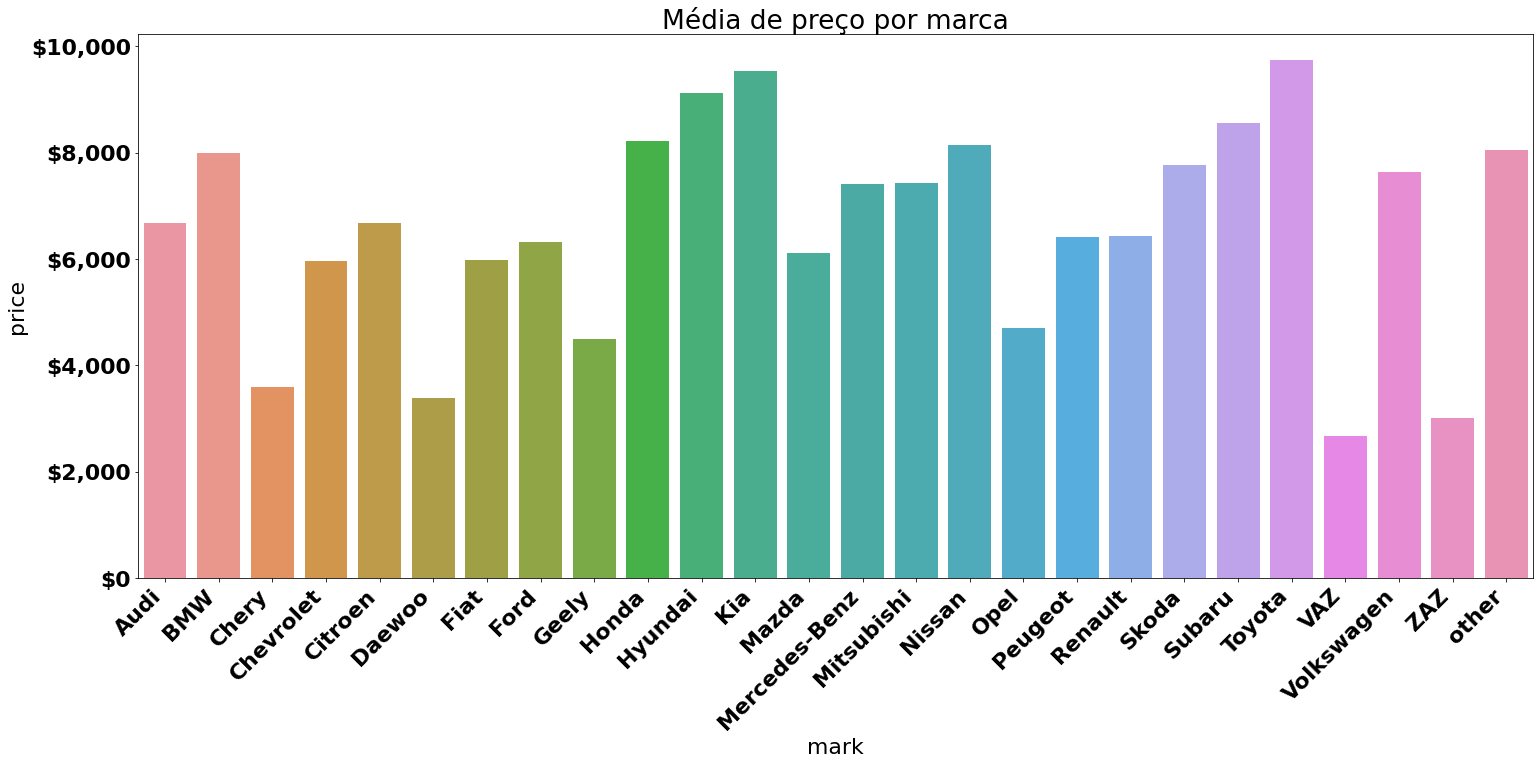

In [ ]:
plt.figure(figsize=(25,10)) 
plt.rc('font', **font)
plt.title('Média de preço por marca')
g = sns.barplot(y=cars_df.groupby('mark')['price'].mean(), x=cars_df.groupby('mark')['price'].mean().index)
g.set_xticklabels(g.get_xticklabels(), rotation = 45, ha="right")
plt.setp(g.get_xticklabels(), fontsize='22') 
plt.setp(g.get_yticklabels(), fontsize='22')
g.set_yticklabels(['${:,}'.format(int(x)) for x in g.get_yticks().tolist()])
plt.show()

### Outliers

> como o modelo que será usado para a previsão é bastante sensível a outliers, é necessário verificar se há muitos e então remover.


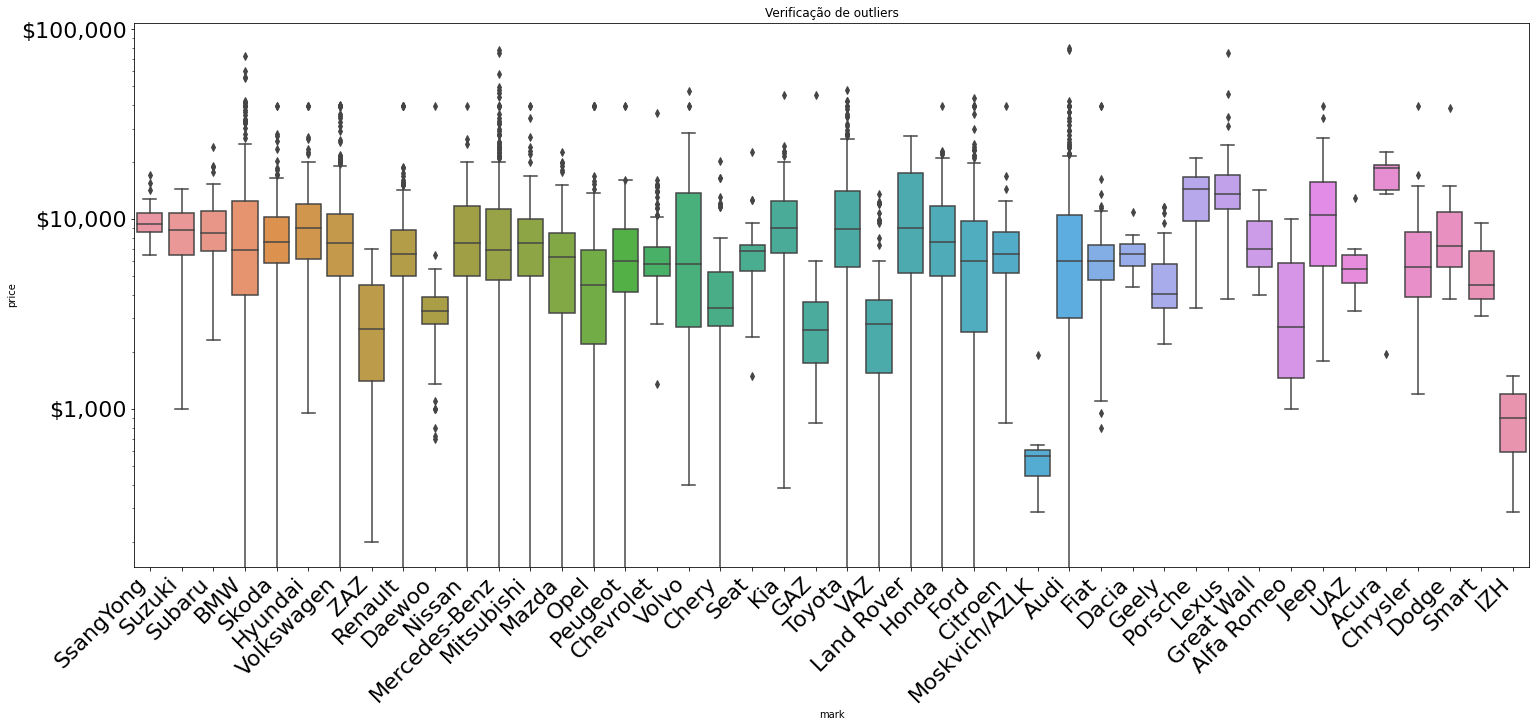

In [ ]:
plt.figure(figsize=(25,10)) 
plt.rc('font', **font)
plt.title('Verificação de outliers')
g = sns.boxplot(y='price', x='mark', data=cars_df)
g.set_yscale("log")
g.set_xticklabels(g.get_xticklabels(), rotation = 45, ha="right")
plt.setp(g.get_xticklabels(), fontsize='22') 
plt.setp(g.get_yticklabels(), fontsize='22') 
g.set_yticklabels(['${:,}'.format(int(x)) for x in g.get_yticks().tolist()])

plt.show()

## Próximo código será para remoção de outliers, vemos que possuímos um número quanto que elevado para as primeiras marcas de carro


In [ ]:
# caso não tenha marca, eu não quero remover. Eu criei uma categoria chamada "other mark" para esse caso
cars_df['mark'] = cars_df['mark'].fillna('Other mark')

In [ ]:
def drop_outliers(df, feature):
    outliers = []
    # Calcula o Q1 (25° percentil) da feature
    Q1 = np.percentile(df[feature], 25)
    
    # Calcula Q3 (75° percentil) da feature
    Q3 = np.percentile(df[feature], 75)
    
    # Utiliza a distância interquartil para calcular o passo do outlier
    # 1.5 é um valor usado como consenso
    step = 1.5 * (Q3 - Q1)
    
    return df[((df[feature] >= Q1 - step) & (df[feature] <= Q3 + step))]

In [ ]:
def drop_outlier_by_brand(df):
  df_to_clean = df.copy()
  brands = cars_df['mark'].unique()

  for brand in brands:
    groupedBrand = df_to_clean[df_to_clean['mark'] == brand]
    df_to_clean[df_to_clean['mark'] == brand] = drop_outliers(groupedBrand, 'price')
  
  return df_to_clean

In [ ]:
cars_df = drop_outlier_by_brand(cars_df)

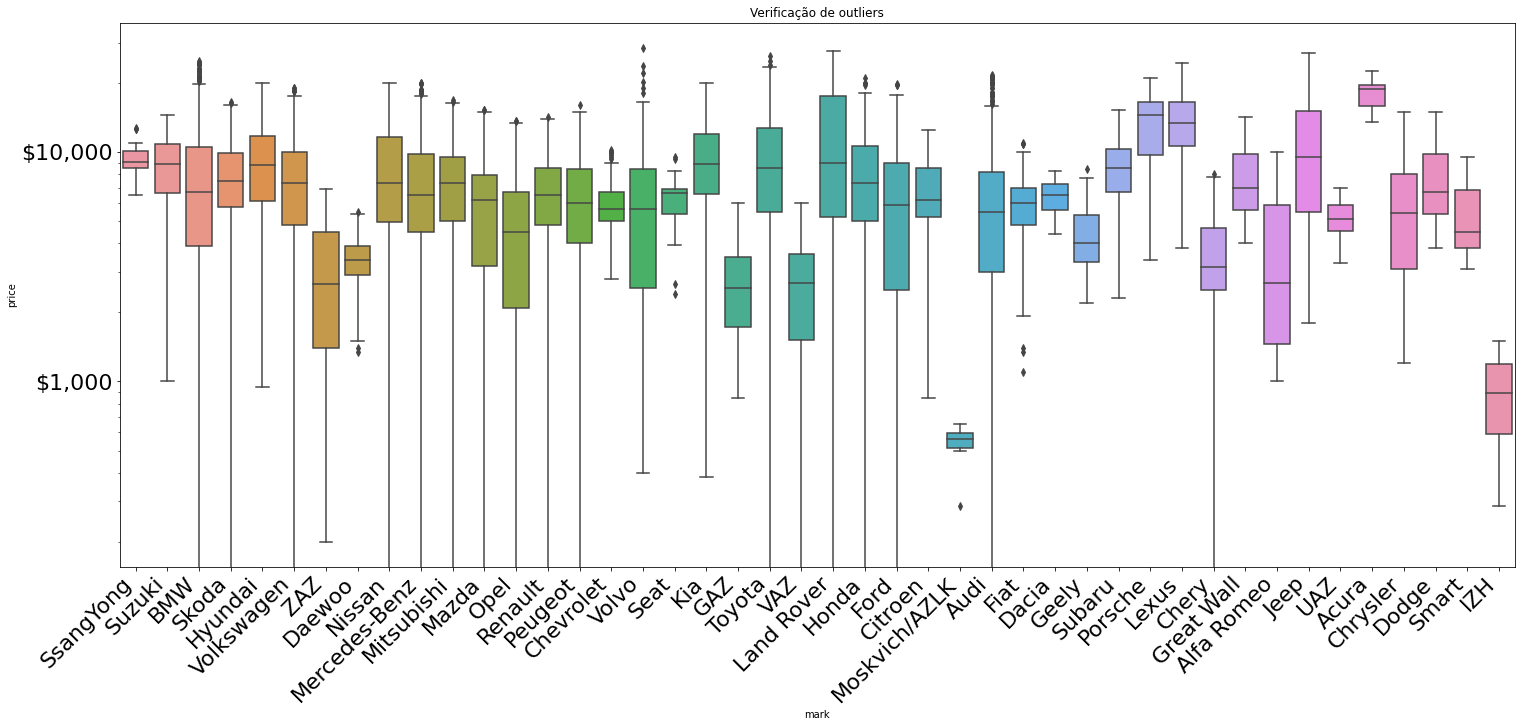

In [ ]:
plt.figure(figsize=(25,10)) 
plt.title('Verificação de outliers')
g = sns.boxplot(y='price', x='mark', data=cars_df)
g.set_yscale("log")
g.set_xticklabels(g.get_xticklabels(), rotation = 45, ha="right")
plt.setp(g.get_xticklabels(), fontsize='22') 
plt.setp(g.get_yticklabels(), fontsize='22') 
g.set_yticklabels(['${:,}'.format(int(x)) for x in g.get_yticks().tolist()])
plt.show()


> Podemos ver no gráfico acima que conseguimos reduzir bastante a quantidade de outliers.

### Criando variável categórica

Aqui irei usar informação deste link: https://www.numbeo.com/cost-of-living/country_result.jsp?country=Ukraine

Nele há um valor médio de um carro, que no brasil é considerado médio em termos de luxo e valor, de $22.898,56 novo. Nessa valor, ficariam muito carros a baixo e talvez afete a precisão.
Por conta disto, irei pegar o maior valor da décima marca que apresenta a média mais barata. Essa escolha foi totalmente ao acaso.

* Até o valor mais alto = barato
* Acima do valor e até 30000 = médio
* Acima do valor = luxo



In [ ]:
cars_df.groupby('mark')['price'].mean().sort_values()

mark
Moskvich/AZLK      527.333333
IZH                894.000000
VAZ               2659.646192
GAZ               2752.026316
ZAZ               3012.160000
Daewoo            3389.495050
Chery             3586.045455
Alfa Romeo        4139.363636
Geely             4485.457143
Opel              4702.224609
UAZ               5161.500000
Smart             5355.764706
Chevrolet         5960.559006
Fiat              5974.641975
Chrysler          6070.454545
Mazda             6113.817647
Seat              6196.185185
Ford              6317.787611
Peugeot           6418.866242
Renault           6427.602210
Dacia             6447.473684
Audi              6676.118211
Citroen           6683.545455
Mercedes-Benz     7408.973684
Mitsubishi        7433.103261
Volvo             7529.695652
Volkswagen        7642.496580
Skoda             7760.996283
Dodge             7793.666667
BMW               7996.354115
Great Wall        8033.222222
Nissan            8148.203883
Honda             8207.549020
Subar

In [ ]:
# Selecionei essas marcar para usar de referência. Escolhi de forma aleatória
cheapPrice = cars_df[cars_df['mark'] == 'Chery']['price'].mean()
intermediaryPrice = cars_df[cars_df['mark'] == 'Chevrolet']['price'].mean()
expensivePrice = cars_df[cars_df['mark'] == 'Kia']['price'].mean()

In [ ]:
def getType(value):
  if (value <= cheapPrice):
    return "cheap"
  if (cheapPrice < value and value <= intermediaryPrice):
    return "medium"
  if (intermediaryPrice < value and value <= expensivePrice):
    return "expensive"
  return "luxury"

In [ ]:
cars_df['category'] = cars_df.price.apply(getType)

In [ ]:
# Depois do processo
cars_df['category'].unique()

array(['luxury', 'expensive', 'medium', 'cheap'], dtype=object)

> Aqui eu decidi agrupar marcas e modelos com uma quantidade pequena de contagem, para uma categoria genérica e comum.

In [ ]:
def getMark(mark):
  count = cars_df[cars_df['mark'] == mark]['mark'].count()
  if (count < 50):
    return 'other'
  else:
    return mark

def getModel(model):
  count = cars_df[cars_df['model'] == model]['model'].count()
  if (count < 5):
    return 'other'
  else:
    return model

In [ ]:
cars_df['mark'] = cars_df.mark.apply(getMark)
cars_df['model'] = cars_df.model.apply(getModel)


# Traduzindo as condições e aplicando o hot encoding

In [ ]:
cars_df.condition = cars_df.condition.fillna("['other']")
cars_df.condition = cars_df.condition.apply(lambda value : literal_eval(value))

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
cars_df.columns

Index(['unnamed: 0', 'title', 'pub_date', 'views', 'city', 'region', 'mark',
       'model', 'year', 'mileage', 'body_type', 'color', 'engine_vol', 'fuel',
       'gearbox', 'cleared', 'condition', 'add_opt', 'multimedia', 'security',
       'other', 'owner_note', 'price', 'category'],
      dtype='object')

> aplicando em diversas colunas

In [ ]:
mlb = MultiLabelBinarizer()
cars_df_encoding = pd.DataFrame(mlb.fit_transform(cars_df['condition']),columns=mlb.classes_)
cars_df_bin = pd.concat([cars_df,cars_df_encoding], axis=1)
cars_df_bin = pd.concat([cars_df_bin.drop("city", axis=1), pd.get_dummies(cars_df.city, prefix='city')], axis=1)
cars_df_bin = pd.concat([cars_df_bin.drop("region", axis=1), pd.get_dummies(cars_df.region, prefix='region')], axis=1)
cars_df_bin = pd.concat([cars_df_bin.drop("gearbox", axis=1), pd.get_dummies(cars_df.gearbox, prefix='gearbox')], axis=1)
cars_df_bin = pd.concat([cars_df_bin.drop("color", axis=1), pd.get_dummies(cars_df.color, prefix='color')], axis=1)
cars_df_bin = pd.concat([cars_df_bin.drop("model", axis=1), pd.get_dummies(cars_df.model, prefix='model')], axis=1)
cars_df_bin = pd.concat([cars_df_bin.drop("mark", axis=1), pd.get_dummies(cars_df.mark, prefix='mark')], axis=1)
cars_df_bin = pd.concat([cars_df_bin.drop("category", axis=1), pd.get_dummies(cars_df.category)], axis=1)

cars_df_bin_droped = cars_df_bin.drop(
    ['unnamed: 0', 'pub_date', 'title', 'body_type', 'fuel', 'condition', 'owner_note', 'other', 'add_opt', 'multimedia', 'security'], axis=1).copy()

In [ ]:
translation = {
    "Гаражное хранение": "Garage storage",
    "Первый владелец": "The first owner",
    "Не бит": "Not a bit",
    "Первая регистрация": "The first registration",
    "Не крашен": "Not painted",
    "Требует ремонта": "Requires repair",
    "Сервисная книжка": "Service book",
    "После ДТП": "After the accident",
    "Не на ходу": "Not on the go",
    "Взято в кредит": "Borrowed",
}

In [ ]:
cars_df_bin_droped.rename(columns=translation, inplace=True)

In [ ]:
cars_df_bin_droped.head(2)

,views,year,mileage,engine_vol,cleared,price,Borrowed,Garage storage,Not a bit,Not painted,Not on the go,The first registration,The first owner,After the accident,Service book,Requires repair,city_Авангард,city_Авдеевка,city_Акимовка,city_Александрия,city_Александровск,city_Алексеевка,city_Алтестовое,city_Алчевск,city_Ананьев,city_Андрушевка,city_Антоновка,city_Антрацит,city_Апостолово,city_Артемовка,city_Артемовск,city_Арциз,city_Ахтырка,city_Балаклея,city_Баловка,city_Баловное,city_Балта,city_Бар,city_Барашевка,city_Барвенково,...,model_X3,model_X5,model_XC90,model_Yaris,model_Zafira,model_haval,model_i30,model_ix35,model_other,model_Другая,mark_Audi,mark_BMW,mark_Chery,mark_Chevrolet,mark_Citroen,mark_Daewoo,mark_Fiat,mark_Ford,mark_Geely,mark_Honda,mark_Hyundai,mark_Kia,mark_Mazda,mark_Mercedes-Benz,mark_Mitsubishi,mark_Nissan,mark_Opel,mark_Peugeot,mark_Renault,mark_Skoda,mark_Subaru,mark_Toyota,mark_VAZ,mark_Volkswagen,mark_ZAZ,mark_other,cheap,expensive,luxury,medium
0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,68.0,2013.0,76000.0,2000.0,1.0,12600.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


# Começando o modelo

### Faço a remoção de linha com valores NaN. O modelo Random Forest não lida muito bem com esse tipo de dado

In [ ]:
cars_df_bin_droped.dropna(inplace=True)

### Começo então a fazer a separação de dados de treino, teste e validação

In [ ]:
x, y = cars_df_bin_droped.drop('price', axis=1), cars_df_bin_droped.price, 

In [ ]:
print("X", x.shape)
print("y", y.shape)

X (2128, 1104)
y (2128,)


In [ ]:
X_training, X_test, y_training, y_test = train_test_split(x, y, test_size=0.25)

X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.33)

In [ ]:
params = {'n_estimators': [5, 50, 100, 500],
          'max_features': [504],
          'max_depth': [5, 10, 20],}

# criando o objeto do modelo com RandomForestRegressor. Regressor, pois é regressão linear
rf_model_cv_gs = RandomForestRegressor()

skf = StratifiedKFold(n_splits=3, shuffle=True)

# criando o objeto do grid search com GridSearchCV
grid_search = GridSearchCV(rf_model_cv_gs, 
                           param_grid=params, 
                           cv=skf.split(X_training, y_training), 
                           return_train_score=True, scoring='neg_root_mean_squared_error')

# treinando o modelo com o grid search
grid_search.fit(X_training, y_training)

# pegando os resultados da validação cruzada (cv_results)
cv_results = pd.DataFrame(grid_search.cv_results_)

# pegando e imprimindo a melhor combinação de hiperparâmetros
cv_best_params = grid_search.best_params_
print('\n Best hyperparameters:')
print(cv_best_params)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)



 Best hyperparameters:
{'max_depth': 10, 'max_features': 504, 'n_estimators': 500}


In [ ]:
# configurando o modelo com a melhor combinação de hiperparâmetros
rf_model_cv_gs.set_params(n_estimators = 50,
                        max_depth = 10,
                        max_features=504)

# treinando um modelo com a melhor combinação de hiperparâmetros
rf_model_cv_gs.fit(X_training, y_training)
best_model_params = rf_model_cv_gs.get_params()

### Uma medida para verificar a precisão RMSE

In [ ]:
y_test_pred_rf = rf_model_cv_gs.predict(X_test)
rmse_test_rf = math.sqrt(mean_squared_error(y_test, y_test_pred_rf))
print(rmse_test_rf)

1469.7393067644216


### R2


In [ ]:
y_val_pred = rf_model_cv_gs.predict(X_val)

In [ ]:
print("Test R² Score: {:.3f}".format(r2_score(y_test, y_test_pred_rf)))
print("Validation R² Score: {:.3f}".format(r2_score(y_val, y_val_pred)))


Test R² Score: 0.891
Validation R² Score: 0.960


# Vamos checar algumas previsões manuais

In [ ]:
cars_df_bin_droped.loc[2,'price']

8150.0

In [ ]:
rf_model_cv_gs.predict(cars_df_bin_droped.drop('price', axis=1).iloc[[2]])

array([6965.39974532])

In [ ]:
cars_df_bin_droped[cars_df_bin_droped['price']<3000].loc[[38]]

,views,year,mileage,engine_vol,cleared,price,Borrowed,Garage storage,Not a bit,Not painted,Not on the go,The first registration,The first owner,After the accident,Service book,Requires repair,city_Авангард,city_Авдеевка,city_Акимовка,city_Александрия,city_Александровск,city_Алексеевка,city_Алтестовое,city_Алчевск,city_Ананьев,city_Андрушевка,city_Антоновка,city_Антрацит,city_Апостолово,city_Артемовка,city_Артемовск,city_Арциз,city_Ахтырка,city_Балаклея,city_Баловка,city_Баловное,city_Балта,city_Бар,city_Барашевка,city_Барвенково,...,model_X3,model_X5,model_XC90,model_Yaris,model_Zafira,model_haval,model_i30,model_ix35,model_other,model_Другая,mark_Audi,mark_BMW,mark_Chery,mark_Chevrolet,mark_Citroen,mark_Daewoo,mark_Fiat,mark_Ford,mark_Geely,mark_Honda,mark_Hyundai,mark_Kia,mark_Mazda,mark_Mercedes-Benz,mark_Mitsubishi,mark_Nissan,mark_Opel,mark_Peugeot,mark_Renault,mark_Skoda,mark_Subaru,mark_Toyota,mark_VAZ,mark_Volkswagen,mark_ZAZ,mark_other,cheap,expensive,luxury,medium
38,71.0,2005.0,300000.0,1300.0,1.0,2700.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
rf_model_cv_gs.predict(cars_df_bin_droped.drop('price', axis=1).loc[[38]])


array([2839.18808065])

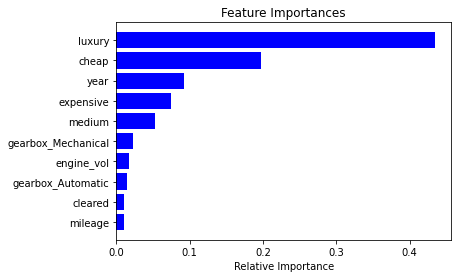

In [ ]:
features = X_training.columns
importances = rf_model_cv_gs.feature_importances_
indices = np.argsort(importances)

feature_importances_df = pd.DataFrame({'features': features,
                                       'importances': importances})

plt.title('Feature Importances')
plt.barh(range(len(importances[indices][-10:])), importances[indices][-10:], color='b', align='center')
plt.yticks(range(len(importances[indices][-10:])), [features[i] for i in indices[-10:]])
plt.xlabel('Relative Importance')
plt.show()

> O gráfico acima exibe, em ordem, as variáveis que mais explicam o modelo, em outras palavras, que mais ajudam a prever o valor do carro. Podemos ver que categorizar os carros em categorias, ajuda bastante a prever o valor. 

Um detalhe é que os dados não possuem a categoria, caso fosse ser usado num modelo em produção, seria necessário indicar essa valor também.

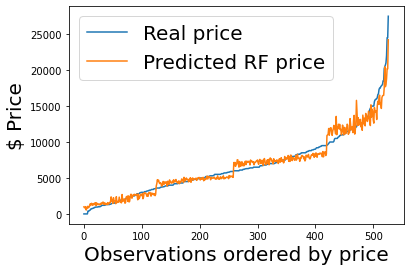

In [ ]:
df = pd.DataFrame({'real':y_val,'Random Forest':rf_model_cv_gs.predict(X_val)})
# df = df.sample(200)

df.sort_values(by=['real'],ascending=True,inplace=True)
df = df.reset_index(drop=True)

plt.plot(df)
plt.legend(['Real price','Predicted RF price'],fontsize=20)
plt.ylabel('$ Price',fontsize=20)
plt.xlabel('Observations ordered by price',fontsize=20)
plt.show()

> Acima, podemos ver em azul os valores reais e em laranja, os valores previstos. Podemos perceber que há quebras e isso pode ser por conta das categorias criadas.

### Tentativa sem o modelo de carro
Aqui eu tentei criar mais um vez o modelo, mas sem usar o modelo do carro. No gráfico de importância das variáveis, nenhum modelo de carro ficou entre as primeiras. Por isso, quis verificar se a precisão melhoraria sem usar o modelo do carro.

In [ ]:
cars_df_encoding2 = pd.DataFrame(mlb.fit_transform(cars_df['condition']),columns=mlb.classes_)
cars_df_bin2 = pd.concat([cars_df,cars_df_encoding2], axis=1)
cars_df_bin2 = pd.concat([cars_df_bin2.drop("city", axis=1), pd.get_dummies(cars_df.city, prefix='city')], axis=1)
cars_df_bin2 = pd.concat([cars_df_bin2.drop("region", axis=1), pd.get_dummies(cars_df.region, prefix='region')], axis=1)
cars_df_bin2 = pd.concat([cars_df_bin2.drop("gearbox", axis=1), pd.get_dummies(cars_df.gearbox, prefix='gearbox')], axis=1)
cars_df_bin2 = pd.concat([cars_df_bin2.drop("color", axis=1), pd.get_dummies(cars_df.color, prefix='color')], axis=1)
cars_df_bin2 = pd.concat([cars_df_bin2.drop("mark", axis=1), pd.get_dummies(cars_df.mark, prefix='mark')], axis=1)
cars_df_bin2 = pd.concat([cars_df_bin2.drop("category", axis=1), pd.get_dummies(cars_df.category)], axis=1)

cars_df_bin2_droped = cars_df_bin2.drop(
    ['unnamed: 0', 'pub_date', 'title', 'body_type', 'fuel', 'model', 'condition', 'owner_note', 'other', 'add_opt', 'multimedia', 'security'], axis=1).copy()

cars_df_bin2_droped.dropna(inplace=True)

In [ ]:
x, y = cars_df_bin2_droped.drop('price', axis=1), cars_df_bin2_droped.price

In [ ]:
print("X", x.shape)
print("y", y.shape)

X (2128, 858)
y (2128,)


In [ ]:
X_training, X_test, y_training, y_test = train_test_split(x, y, test_size=0.25)

X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.33)

In [ ]:
# configurando o modelo com a melhor combinação de hiperparâmetros
rf_model_cv_gs.set_params(n_estimators = 50,
                        max_depth = 20,
                        max_features=804)

# treinando um modelo com a melhor combinação de hiperparâmetros
rf_model_cv_gs.fit(X_training, y_training)
best_model_params = rf_model_cv_gs.get_params()

### Uma medida para verificar a precisão RMSE

y_test_pred_rf = rf_model_cv_gs.predict(X_test)
rmse_test_rf = math.sqrt(mean_squared_error(y_test, y_test_pred_rf))
print("RMSE: {:.3f}".format(rmse_test_rf))



y_val_pred = rf_model_cv_gs.predict(X_val)

### R2
print("Test R² Score: {:.3f}".format(r2_score(y_test, y_test_pred_rf)))
print("Validation R² Score: {:.3f}".format(r2_score(y_val, y_val_pred)))


RMSE: 1598.245
Test R² Score: 0.874
Validation R² Score: 0.984


In [ ]:
cars_df_bin2_droped.loc[2,'price']

8150.0

In [ ]:
rf_model_cv_gs.predict(cars_df_bin2_droped.drop('price', axis=1).iloc[[2]])

array([6779.88387013])

### Sem modelo


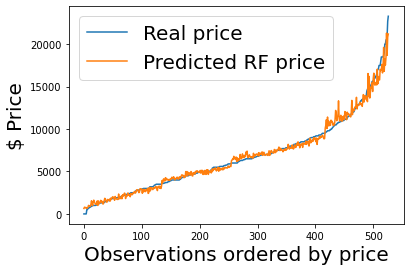

In [ ]:
#@title
df = pd.DataFrame({'real':y_val,'Random Forest':rf_model_cv_gs.predict(X_val)})
# df = df.sample(200)

df.sort_values(by=['real'],ascending=True,inplace=True)
df = df.reset_index(drop=True)

plt.plot(df)
plt.legend(['Real price','Predicted RF price'],fontsize=20)
plt.ylabel('$ Price',fontsize=20)
plt.xlabel('Observations ordered by price',fontsize=20)
plt.show()

> Podemos ver uma melhora acima, sem o modelo e com mudança nos hiperparâmetros.